# Usando datos de twitch para ejercitar dash (y otras cosas)

In [1]:
import numpy as np  #Importar las bibliotecas iniciales
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Las siguientes bibliotecas son para la creación de gráficas interactivas
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import subplots
import plotly.express as px

#Las siguiente bibliotecas son para la creación de dashboard interactivos
import dash
from dash import html
from dash import dcc

from dash.dependencies import Input, Output

import json

from siuba import *  #Un biblioteca que ayuda a generar consultas de mejor manera (complementario a pandas)

Los datos fueron obtenidos de [kaggle](https://www.kaggle.com/datasets/rankirsh/evolution-of-top-games-on-twitch).

In [7]:
data = pd.read_csv("C:/Users/solk1/OneDrive/Desktop/Ciencia de datos/Dashboards_python/Twitch_game_data.csv",
                  encoding = "latin-1") #Imporando datos
print(data.shape)
data.head()

(16800, 12)


,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044 hours,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105 hours,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397 hours,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903 hours,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578 hours,71639,3620,214054,21740,1549,14.03


In [3]:
data.info() #Notar que varios datos de interés (de la columna 4 en adelante) no son numéricos, eso lo arreglaré más adelante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rank              16800 non-null  int64 
 1   Game              16799 non-null  object
 2   Month             16800 non-null  int64 
 3   Year              16800 non-null  int64 
 4   Hours_watched     16800 non-null  object
 5   Hours_Streamed    16800 non-null  object
 6   Peak_viewers      16800 non-null  object
 7   Peak_channels     16800 non-null  object
 8   Streamers         16800 non-null  object
 9   Avg_viewers       16800 non-null  object
 10  Avg_channels      16800 non-null  object
 11  Avg_viewer_ratio  16800 non-null  object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB


In [61]:
data.isnull().sum() #Hay un juego que no tiene nombre, lo eliminaré

Rank                0
Game                1
Month               0
Year                0
Hours_watched       0
Hours_Streamed      0
Peak_viewers        0
Peak_channels       0
Streamers           0
Avg_viewers         0
Avg_channels        0
Avg_viewer_ratio    0
dtype: int64

In [4]:
data[data["Game"].isnull()] #Viendo que index tiene ese valor nulo

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
7561,162,NaN,2,2019,317951,77004 hours,30919,5804,21758,473,114,4.13


In [8]:
data = data.drop([7561], axis = 0) #Eliminando el valor con el dato nulo

In [9]:
data.isnull().sum() #Ya quedó

Rank                0
Game                0
Month               0
Year                0
Hours_watched       0
Hours_Streamed      0
Peak_viewers        0
Peak_channels       0
Streamers           0
Avg_viewers         0
Avg_channels        0
Avg_viewer_ratio    0
dtype: int64

In [10]:
for i in data.columns[4:]: #Para quitar el texto de los registros en aquellas columnas que las combertiré en int64
    data[i] = data[i].str.extract("(\d+)") 

In [11]:
for i in data.columns[4:]:  #Y aquí es para pasar de datos tipo string a tipo int
    data[i] = data[i].astype("int64")

In [12]:
data["Year"] = data["Year"].astype("string") #Para justar el año y el mes, lo combierto a string
data["Month"] = data["Month"].astype("string") 

In [13]:
data["Fecha"] = data.Year.str.cat(data.Month, sep = "-")
data.head()

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Fecha
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69,2016-1
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57,2016-1
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104,2016-1
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169,2016-1
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14,2016-1


In [14]:
data["Fecha"] = pd.to_datetime(data["Fecha"]) #Y convierto esa nueva columna de fecha a tipo datetime
data.head()

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Fecha
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69,2016-01-01
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57,2016-01-01
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104,2016-01-01
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169,2016-01-01
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14,2016-01-01


In [15]:
data = data.drop(["Rank"], axis = 1) #La columna de Rank no es necesaria, es el index basicamente

In [13]:
data.head()

,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Fecha
0,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69,2016-01-01
1,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57,2016-01-01
2,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104,2016-01-01
3,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169,2016-01-01
4,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14,2016-01-01


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16799 entries, 0 to 16799
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Game              16799 non-null  object        
 1   Month             16799 non-null  string        
 2   Year              16799 non-null  string        
 3   Hours_watched     16799 non-null  int64         
 4   Hours_Streamed    16799 non-null  int64         
 5   Peak_viewers      16799 non-null  int64         
 6   Peak_channels     16799 non-null  int64         
 7   Streamers         16799 non-null  int64         
 8   Avg_viewers       16799 non-null  int64         
 9   Avg_channels      16799 non-null  int64         
 10  Avg_viewer_ratio  16799 non-null  int64         
 11  Fecha             16799 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(1), string(2)
memory usage: 1.7+ MB


In [17]:
#Como pruebas, veo para cada juego, el total de vistas contra el total de horas en streaming para cada año
data1 = (data >> group_by(_.Game, _.Year) >>
         summarize(Total_vistas = _.Hours_watched.sum(), Total_streamed = _.Hours_Streamed.sum()) >>
         arrange(-_.Total_vistas)
        )
data1.head(10)

,Game,Year,Total_vistas,Total_streamed
1584,Just Chatting,2022,3139111208,35454882
1583,Just Chatting,2021,3020771657,38697240
1582,Just Chatting,2020,1995891029,28458987
1308,Grand Theft Auto V,2021,1874989023,25465235
1691,League of Legends,2021,1735661105,37975030
1692,League of Legends,2022,1556699612,27952114
1690,League of Legends,2020,1553536532,38273316
1309,Grand Theft Auto V,2022,1414287042,23867924
1150,Fortnite,2018,1358048914,79568446
3538,VALORANT,2022,1159768684,43142243


In [23]:
cuadro = [go.Scatter(  #Indico que será un gráfica tipo scatter
    x = data1["Total_streamed"],
    y = data1["Total_vistas"],
    mode = "markers",
    text = data1["Game"],
    marker = {
        "color": "red"
    }
)]

layout = go.Layout(
    title = "Streaming vs Visitas",
    xaxis = {"title": "Total en horas de streaming"},
    yaxis = {"title": "Total de horas de Visitas"}
)

fig = go.Figure(data = cuadro, layout = layout)

fig.show()

Solo estamos viendo una relación general de las horas vistas con respecto al total de horas en streaming para todos los juegos, sin embargo, para una mejor visualización, querremos separar estos datos con respecto a cada año, para eso es la siguiente gráfica.

In [24]:
fig = px.scatter(data1, x = "Total_streamed", y = "Total_vistas", color = "Year")
fig.show()  #Veo como

Pero aún sigue siendo mucha información como para que se concentre en una sola gráfica, por lo que el siguiente código es para mostrar el uso de un dashboard (usando **dash**  que funciona en conjunto con algunas características de HTML y CSS, como se aprecia al inicio), junto con gráficas interactivas. 
  
Presento dos plots, el primero es similar a los pasados, viendo el total de horas en streaming con respecto al total de horas de vistas para cada juego, pero se verá la separación por año, usando un dropdown, además de mostrar con un punto rojo el juego del que se este mostrando en la siguiente gráfica. 
  
El segundo plot es de tipo temporal, ya que muestro la evolución de las vistas y de las horas en streaming (en *porcentaje*) de un solo juego. Se puede elejir el juego con otro dropdown.

In [50]:
app = dash.Dash()

app.layout = html.Div([ #Esta es la parte de la creación del dashboard, en donde inidico el lugar en donde estarán los plot y los dropdown.
    html.Div([
        dcc.Dropdown(id = "anio", options = [{"label": i, "value": i} for i in data1["Year"].unique()], value = "2016")
    ], style = {"width":"45%", "display": "inline-block"}
    ),
    html.Div([
        dcc.Dropdown(id = "juego", options = [{"label": i, "value": i} for i in data1["Game"].unique()], value = "Fortnite")
    ], style = {"width":"45%", "display": "inline-block", "float": "right"}
    ),
    
    html.Div([
        dcc.Graph(id = "plot1")
    ]),
    html.Div([
        dcc.Graph(id = "plot2")
    ])
], style = {"padding": 2, "backgroundColor": "black"}
)

@app.callback(
    Output("plot1", "figure"),
    [Input("anio", "value"), Input("juego", "value")]
)
def actualizar_graph1(año, juego):
    data_f1 = data1[(data1["Year"] == año)]
    data_juego = data1[(data1["Game"] == juego) & (data1["Year"] == año)]
    return {
        "data":[go.Scatter(
            x = data_f1["Total_streamed"],
            y = data_f1["Total_vistas"],
            mode = "markers",
            text = data_f1["Game"],
            name = ""
        ),
               go.Scatter(
            x = data_juego["Total_streamed"],
            y = data_juego["Total_vistas"],
            mode = "markers",
            name = juego,
            marker = {
                "size": 8,
                "color": "red"
            }       
        )],
        
        "layout": go.Layout(
            xaxis = {"title": "Total de horas en streaming"},
            yaxis = {"title": "Total de horas vistas"}
        )
    }


@app.callback(
    Output("plot2", "figure"),
    [Input("juego", "value"), Input("plot1", "clickData")]
)
def actualizar_graph2(juego, clickData):
    
    #v_index = clickData["points"][0]["text"] #Esto se puede añadir para una interactividad entre gráficas.
    
    data_f2 = (data[(data["Game"] == juego)] >>   #En lugar de juego podría ir v_index
                mutate(porcent_vistas = _.Hours_watched*100/_.Hours_watched.max(), 
                       percent_streaming = _.Hours_Streamed*100/_.Hours_Streamed.max())
              ) 
    return {
        "data": [go.Scatter(
            x = data_f2["Fecha"],
            y = data_f2["porcent_vistas"],
            mode = "lines + markers",
            name = "Vistas"
        ),
                go.Scatter(
            x = data_f2["Fecha"],
            y = data_f2["percent_streaming"],
            mode = "lines + markers",
            name = "Horas en Streming"
        )],
        
        "layout": go.Layout(
            title = juego, #Podría ir v_index
            xaxis = {"title": "Fecha"},
            yaxis = {"title": "Horas (%)"}
        )
    }

if __name__ == "__main__":
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [11/Feb/2023 15:20:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2023 15:20:45] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2023 15:20:45] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2023 15:20:45] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2023 15:20:45] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2023 15:20:45] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2023 15:20:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2023 15:20:46] "POST /_dash-update-component HTTP/1.1" 200 -


# Ahora, haciendo un par de regresiones lineales

<AxesSubplot:>

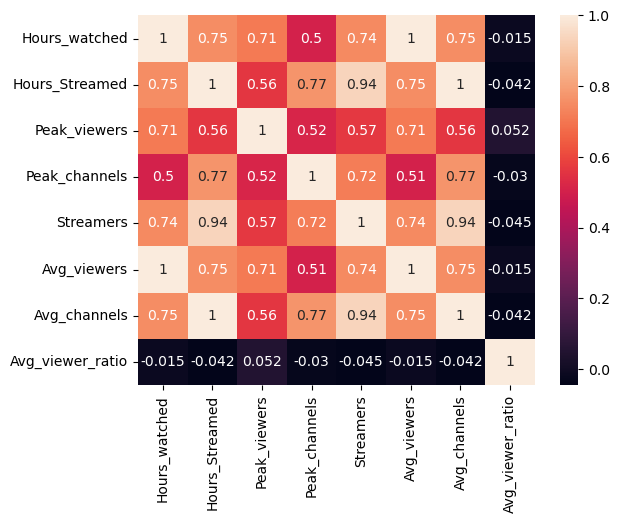

In [26]:
sns.heatmap(data.corr(), annot = True) #Para visualizar la correlación

In [43]:
from sklearn.linear_model import LinearRegression  #Para usar el modelo de Regresión lineal
from sklearn.metrics import mean_squared_error, r2_score #Para obtener el error cuadrático medio y después su raíz, y el valor de R2

In [28]:
datos_regresion = data >> select(_.Hours_watched, _.Hours_Streamed, _.Peak_viewers, _.Peak_channels,
                                 _.Streamers, _.Avg_viewers, _.Avg_channels, _.Avg_viewer_ratio)
datos_regresion.head()

,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,94377226,1362044,530270,2903,129172,127021,1833,69
1,47832863,830105,372654,2197,120849,64378,1117,57
2,45185893,433397,315083,1100,44074,60815,583,104
3,39936159,235903,131357,517,36170,53749,317,169
4,16153057,1151578,71639,3620,214054,21740,1549,14


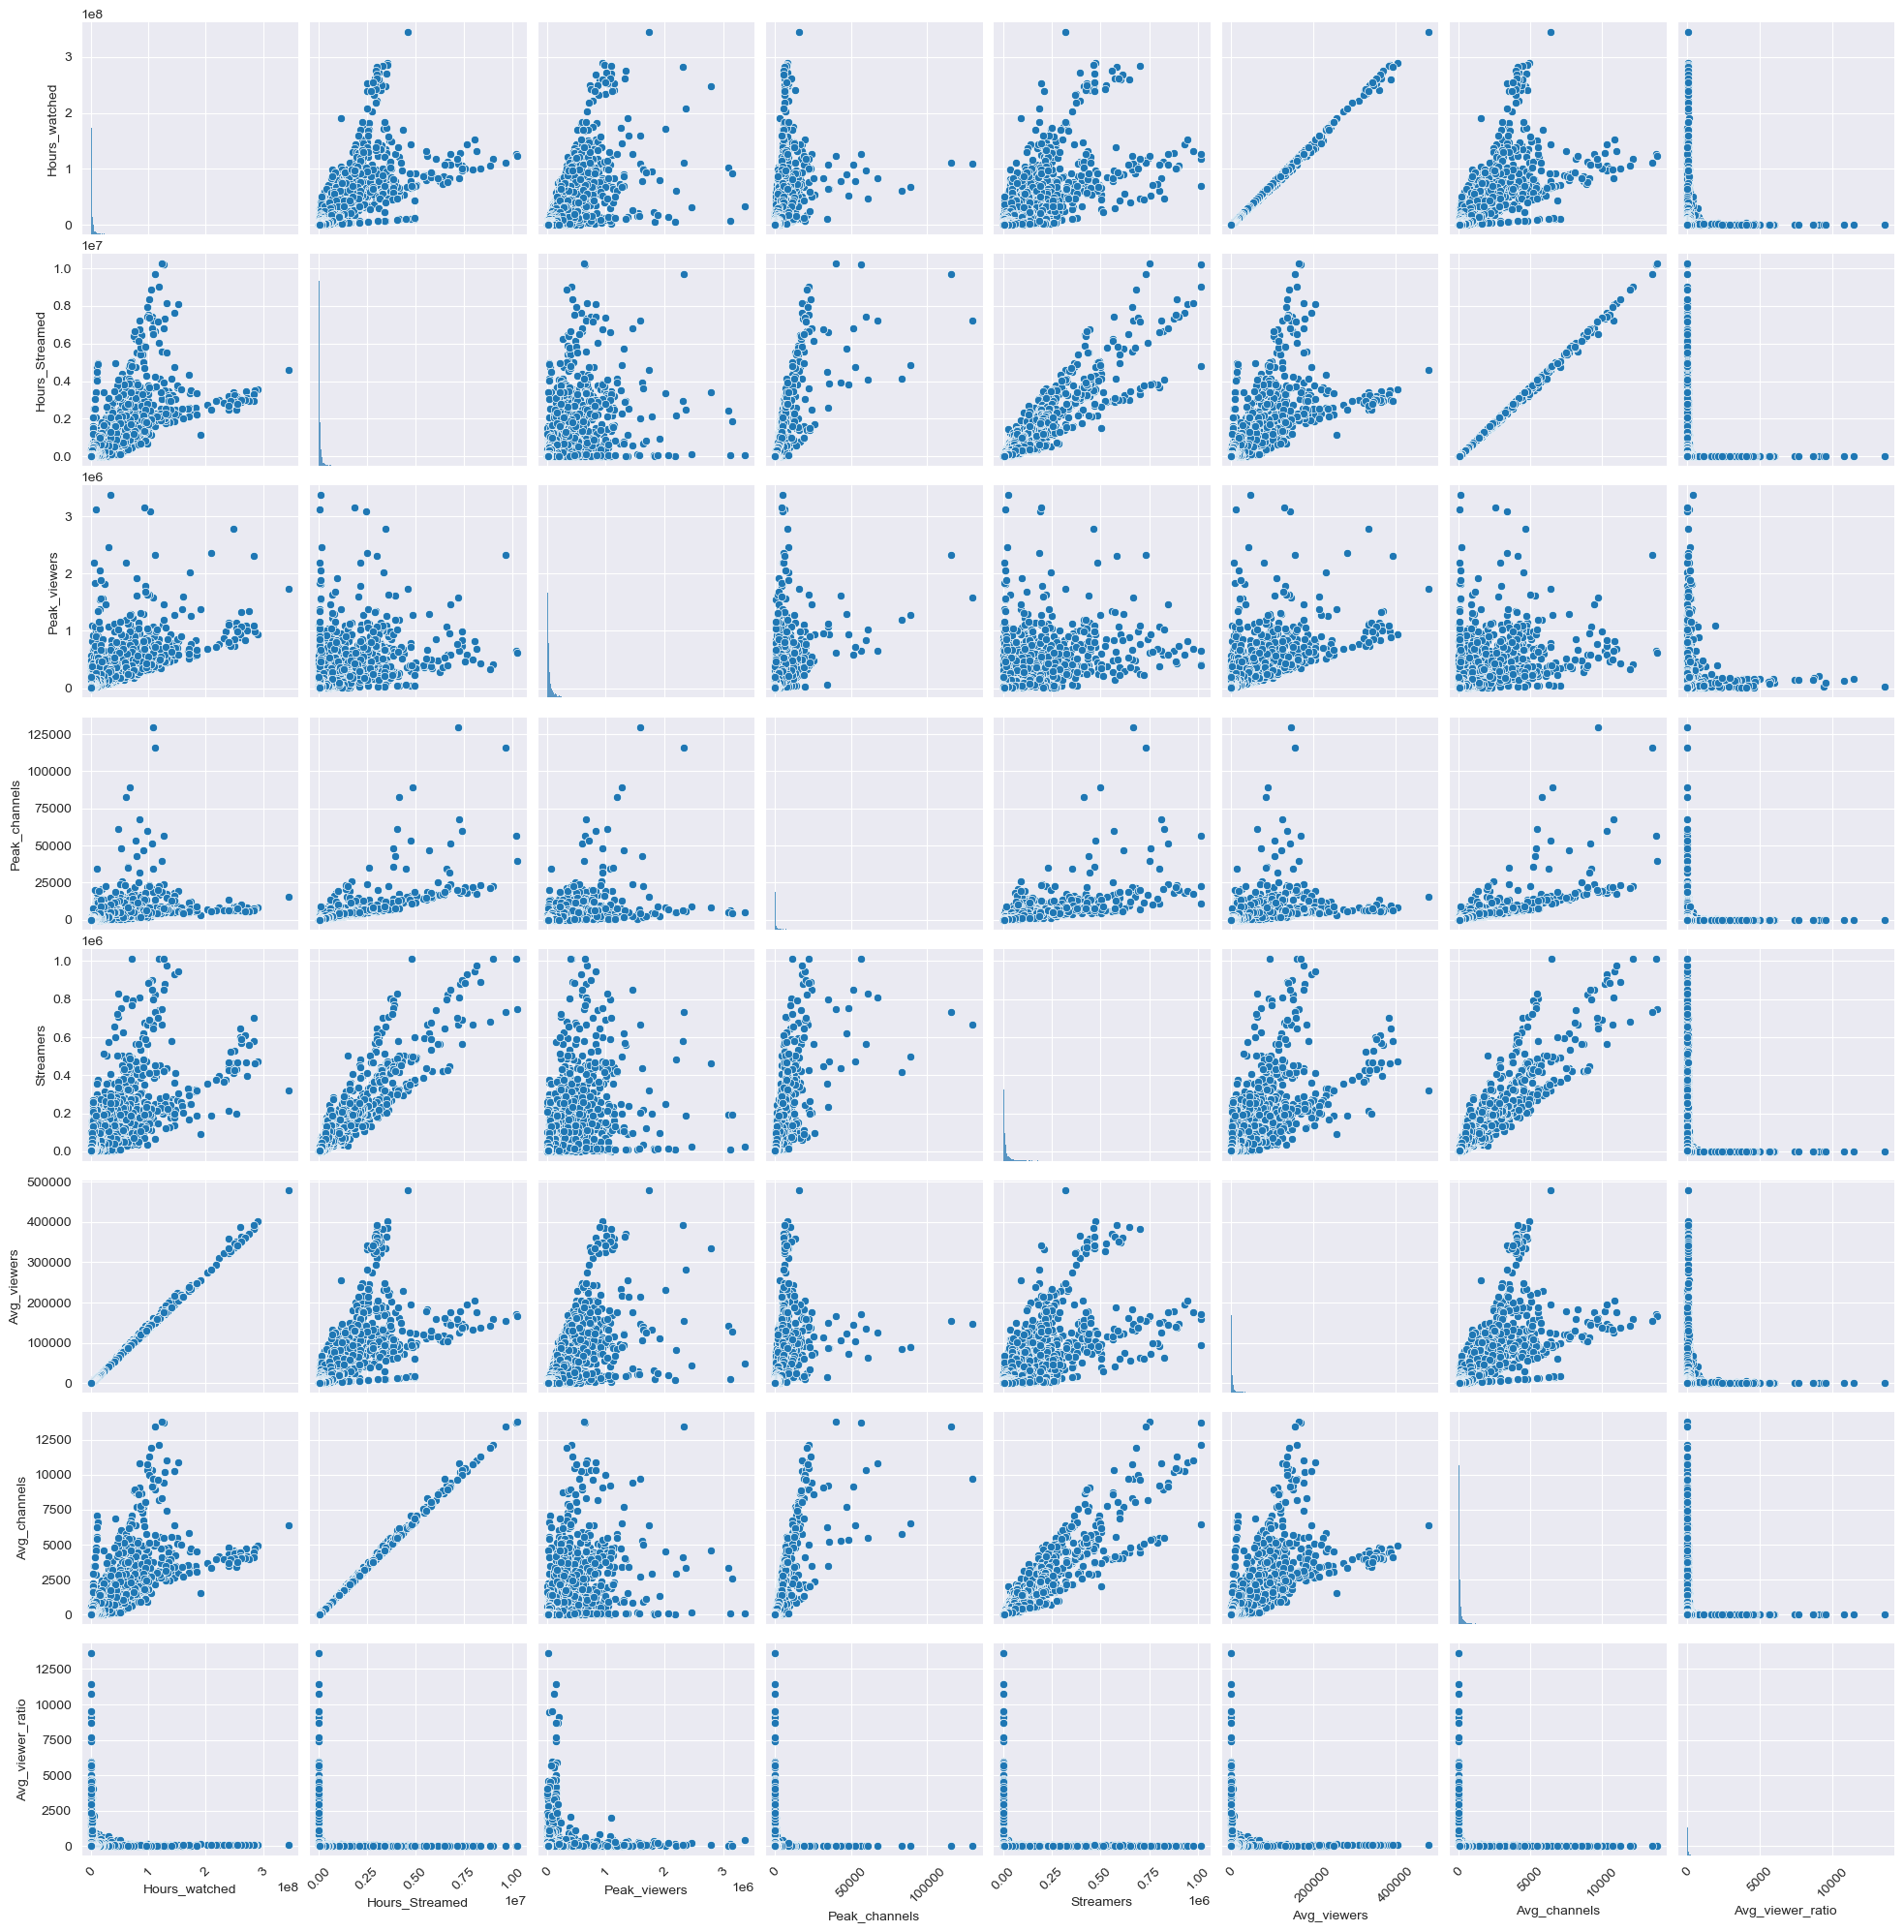

In [28]:
sns.set_style("darkgrid")

g = sns.pairplot(datos_regresion, diag_kind = "hist")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation = 45)

In [29]:
horas_vistas = datos_regresion["Hours_watched"].values
horas_streaming = datos_regresion["Hours_Streamed"].values
pico_vistas = datos_regresion["Peak_viewers"].values
pico_canales = datos_regresion["Peak_channels"].values
streaming = datos_regresion["Streamers"].values
promedio_vistas = datos_regresion["Avg_viewers"].values 
promedio_canales = datos_regresion["Avg_channels"].values
promedio_vistas_ratio = datos_regresion["Avg_viewer_ratio"].values

X = np.array([horas_streaming, pico_vistas, streaming, promedio_canales]).T #Solo agarro los que tiene mayor correlación
Y = np.array(horas_vistas)

In [30]:
reg = LinearRegression()  #Instancio un objeto de tipo LinearRegression
reg = reg.fit(X, Y)  #Lo ajusto con respecto a los datos de entrada y los de salida

In [49]:
Y_pred = reg.predict(X)  #Realizo una predicción, aunque no estoy usando datos test, lo cual se podría realizar
error = np.sqrt(mean_squared_error(Y, Y_pred))
#score = reg.score(X, Y)
r2 = r2_score(Y, Y_pred)

In [47]:
datos_regresion["Hours_watched"].describe()

count    1.679900e+04
mean     5.313669e+06
std      1.822172e+07
min      8.981100e+04
25%      4.206800e+05
50%      9.364410e+05
75%      2.645110e+06
max      3.445520e+08
Name: Hours_watched, dtype: float64

In [48]:
print("Error:", error)
print("r2:", r2)
print("Coeficientes: ", reg.coef_)

Error: 10133062.296947852
r2: 0.69073654515804
Coeficientes:  [  12.41369877   51.09245574   50.74670709 -289.90294986]
